In [1]:
# In this section, I will investigate the behaviour of a time series with Markov switching regimes.
# In particular, the time series is formulated by (stationary) AR(1) process, but the intercept is allowed to switch
# between a(s1) and a(s2) (assume only 2 regimes exist).
# Since we only focus on the Markov switching regime process, the model is allowed to be homoskedastic.
# The model would be:
# y(t) = a(s(t)) + b*y(t-1) + u(s(t)), where u(s(t)) is normally distributed with mean 0 and variance sig(s(t))^2.
# s(t) = 0 or 1, implying 2 regimes we're considering.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import norm

In [2]:
# The algorithm contains ... steps:
# 1. Initialize necessary parameters and probabilities
# 2. Compute the filtering probabilities, which is P(s(t) = i|Y(t), theta) (Y(t) is the information at time t)
# 3. Compute the smoothed probabilities, which is P(s(t) = i|Y(T), theta)
# 4. Estimate the parameters (formulae are provided in Hamilton (1994)) based on the smoothed probabilities

In [3]:
# Construct the likelihood function y(t)|y(t-1)
def likelihood_t(y, u_prob, para):
    # Standardize
    u0 = (y[1] - para[0] - para[2]*y[0])/para[4]
    u1 = (y[1] - para[1] - para[3]*y[0])/para[5]
    # Compute f
    f = u_prob[0]*(1/np.sqrt(2*np.pi))*(1/para[4])*np.exp(-1/2*u0**2) + \
        u_prob[1]*(1/np.sqrt(2*np.pi))*(1/para[5])*np.exp(-1/2*u1**2)
    return f

# Construct the function updating filtering probabilities
def filter_prob(y, u_prob, para):
    f = likelihood_t(y, u_prob, para)
    P = np.zeros((2,1))
    u0 = (y[1] - para[0] - para[2]*y[0])/para[4]
    u1 = (y[1] - para[1] - para[3]*y[0])/para[5]
    P[0] = ((1/np.sqrt(2*np.pi))*(1/para[4])*np.exp(-1/2*u0**2))*u_prob[0]/f
    P[1] = ((1/np.sqrt(2*np.pi))*(1/para[5])*np.exp(-1/2*u1**2))*u_prob[1]/f
    return P.reshape(2,1)

# Construct the function to update P(s(t+1) = i|Y(t), theta)
def update_prob(filtering_prob, para):
    P = np.zeros((2,1))
    P[0] = filtering_prob[0]*para[6] + filtering_prob[1]*(1-para[7])
    P[1] = filtering_prob[0]*(1-para[6]) + filtering_prob[1]*para[7]
    return P.reshape(2,1)

# Now, we compute the smoothed probabilities using algorithm of Kim (1994)
# This algorithm recursively compute this kind of probability backward, taking the last values of filtering probabilities
# as the initial values
def smooth_prob(filtering_prob, para, y):
    smooth_prob = np.zeros((2,len(y)-1))
    smooth_prob[0,-1] = filtering_prob[0,-1]
    smooth_prob[1,-1] = filtering_prob[1,-1]
    l = list(range(1,len(y)-1))[::-1]
    for t in l:
        smooth_prob[0,t-1] = filtering_prob[0,t-1]*(para[6]*smooth_prob[0,t]/filtering_prob[0,t] + \
                                                   (1-para[6])*smooth_prob[1,t]/filtering_prob[1,t])
        smooth_prob[1,t-1] = filtering_prob[1,t-1]*((1-para[7])*smooth_prob[0,t]/filtering_prob[0,t] + \
                                                   para[7]*smooth_prob[1,t]/filtering_prob[1,t])
    return smooth_prob

# Now, construct functions to estimate the parameters
# Firstly, the transition probabilities
def transition_matrix(smooth_prob, para):
    # Compute the joint probabilities
    regime = np.zeros((smooth_prob.shape[1],1))
    for t in range(len(regime)):
        u = np.random.uniform(0,1)
        if u <= smooth_prob[0,t]:
            regime[t] = 0
        else:
            regime[t] = 1
    # Now, we already have the simulated regime based on the smoothed probabilities
    # Next, count the number of each regime
    count_num = np.zeros((2,1))
    count_de = np.zeros((2,1))
    count_de[0] = sum(regime == 0)
    count_de[1] = sum(regime == 1)
    for t in range(1,len(regime)):
        if regime[t-1] == 0 and regime[t] == 0:
            count_num[0] += 1
        elif regime[t-1] == 1 and regime[t] == 1:
            count_num[1] += 1
    # Estimate transition probability matrix
    p00 = count_num[0]/count_de[0]
    p11 = count_num[1]/count_de[1]
    return (np.row_stack((p00, p11))).reshape(2,1)

# Next, the variance
def variance(y, para, smooth_prob):
    if y.shape[0] == 1:
        y = np.transpose(y)
    else:
        y = y
    if smooth_prob.shape[0] == 2:
        s_prob = np.transpose(smooth_prob)
    else:
        s_prob = smooth_prob
    de = s_prob.sum(axis = 0)
    num = np.zeros((1,2))
    for k in range(2):
        num[0][k] = np.multiply(s_prob[:,k], ((y[1:]-para[k]-para[k+2]*y[:len(y)-1])**2).ravel()).sum()
    sig = np.sqrt(np.divide(num, de))
    return sig

# Lastly, the AR(1) coefficients
def AR_coef(y, smooth_prob):
    # Rotate the materials into appropriate directions
    if y.shape[0] == 1:
        y = np.transpose(y)
    else:
        y = y
    if smooth_prob.shape[0] == 2:
        s_prob = np.transpose(smooth_prob)
    else:
        s_prob = smooth_prob
    # State the left-hand side and right-hand side variables
    yt = y[:-1]
    zt = np.column_stack((np.ones((len(yt),1)),y[1:]))
    # For regime 0
    yt0 = np.zeros(yt.shape)
    zt0 = np.zeros(zt.shape)
    for t in range(len(y)-1):
        yt0[t] = yt[t]*np.sqrt(s_prob[t,0])
        zt0[t] = zt[t]*np.sqrt(s_prob[t,0])
    
    # For regime 1
    yt1 = np.zeros(yt.shape)
    zt1 = np.zeros(zt.shape)
    for t in range(len(y)-1):
        yt1[t] = yt[t]*np.sqrt(s_prob[t,1])
        zt1[t] = zt[t]*np.sqrt(s_prob[t,1])
    
    coef0 = np.matmul(inv(np.matmul(np.transpose(zt0),zt0)),np.matmul(np.transpose(zt0),yt0))
    coef1 = np.matmul(inv(np.matmul(np.transpose(zt1),zt1)),np.matmul(np.transpose(zt1),yt1))
    
    coef = np.transpose(np.column_stack((coef0,coef1)))
    return coef

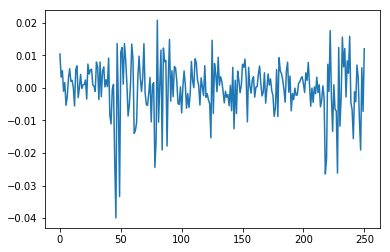

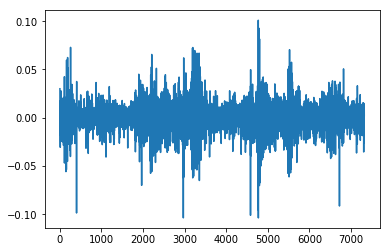

In [4]:
# Real data: NYSE log returns
df1 = pd.read_csv('^NYA.csv')
df1 = pd.DataFrame(df1)

# Convert to log returns
adj_price = df1.iloc[:,5].values
y1 = np.log(adj_price[1:]) - np.log(adj_price[:-1])

# Visualisation
_ = plt.figure
_ = plt.plot(y1)
plt.show()

# Real data: DAX log returns
df2 = pd.read_csv('time_series_dax.csv', delimiter = ';')
df2 = pd.DataFrame(df2)

# Convert to log returns
price = df2.iloc[:,1].values
y2 = np.log(price[1:]) - np.log(price[:-1])

# Visualisation
_ = plt.figure
_ = plt.plot(y2)
plt.show()

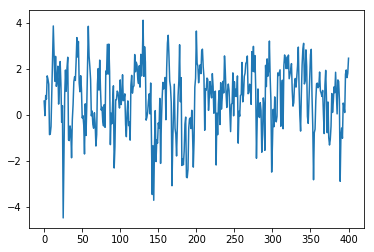

In [5]:
# Simulation
# As usual, I, first, simulate the time series with Markov switching regime process, then, use the synthesis data to estimate.

# First: simulation
y0 = np.random.normal(0,1)

# To create the switching mechanism, the transition probability matrix is needed. A constrain of this matrix is that, it is 
# "irreducible". For the 2-state Markov chain, it means that each diagonal element lies between 0 and 1
p11 = 0.7
p22 = 0.4

# Then, the transition probability matrix is constructed as follow (denoted by P)
P = np.array([[p11, 1-p11],[1-p22, p22]])

# The intercepts of 2 regimes
a0 = 0.7
a1 = -0.5
a = np.array([a0, a1])

# AR process parameter and the variance of the series among 2 regimes.
b = 0.6
sig0 = 0.8
sig1 = 1.4
sig = np.array([sig0, sig1])

# The first regime has higher intercept and smaller variance, it represents for the stable regime in the economy.
# The second is constructed in opposite, thus it denotes the recessive period in the economy.

# Firstly, choose an initial state
s0 = np.random.randint(0,2)
s = np.zeros((500,1))
s[0] = s0

# Draw the initial value of y in an (seemingly) uninformative prior
y0 = np.random.normal(0,50)
y = np.zeros((500,1))
y[0] = y0

for t in range(1,len(y)):
    # For each t, consider the change or not
    test = np.random.uniform(0,1)
    if test > P[int(s[t-1]),int(s[t-1])]:
        s[t] = 1-s[t-1]
    else:
        s[t] = s[t-1]
    ut = np.random.normal(0,sig[int(s[t])])
    y[t] = a[int(s[t])] + b*y[t-1] + ut
    
# Cut off the first observations of y
y3 = y[99:]

# Visualize y
_ = plt.figure
_ = plt.plot(range(len(y3)), y3)
plt.show()

In [6]:
# Use the data
y = y1

# Now, perform iterations
# Firstly, construct the matrices to store the estimated values
S = 1000
para = np.zeros((8,S))
f_prob = np.zeros((2,len(y)-1))
u_prob = np.zeros((2,len(y)-1))

# Initialize them.
u_prob[:,0] = np.array([[0.5], [0.5]]).reshape(2,)

para[:,0] = np.array([[0.5],[0.5],[0.5],[0.5],[0.5],[0.5],[0.7],[0.6]]).reshape(8,)

for s in range(1,S):
    # Compute the filtering and updating probabilities
    for t in range(len(y)-2):
        y_used = y[t:t+2][::-1]
        f_prob[:,t+1] = filter_prob(y_used, u_prob[:,t], para[:,s-1]).reshape(2,)
        u_prob[:,t+1] = update_prob(f_prob[:,t+1], para[:,s-1]).reshape(2,)
    # Compute the smoothed probabilities
    s_prob = smooth_prob(f_prob, para[:,s-1], y)
    # Update the parameters using smoothed probabilities
    # Begin with the transition matrix
    para[6:,s] = transition_matrix(s_prob, para[:,s-1]).reshape(2,)
    # The variance, sigma
    para[4:6,s] = variance(y, para[:,s-1], s_prob).reshape(2,)
    # The AR coefficients
    para[0:2,s] = np.transpose(AR_coef(y, s_prob)[0]).reshape(2,)
    para[2:4,s] = np.transpose(AR_coef(y, s_prob)[1]).reshape(2,)
    # Update the unconditional probabilties

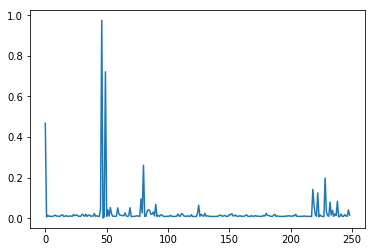

In [7]:
# The smoothed probabilities of regime 1
_ = plt.figure
_ = plt.plot(s_prob[1][1:])
plt.show()

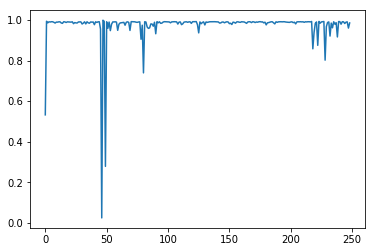

In [10]:
# The smoothed probabilities of regime 0
_ = plt.figure
_ = plt.plot(s_prob[0][1:])
plt.show()

In [9]:
para[:,-1]

array([-2.32497275e-04,  1.91772379e-02,  2.96044218e-03, -1.70356252e-01,
        8.19579540e-03,  1.79001710e-02,  9.62500000e-01,  1.00000000e-01])